# Residential Electricity Consumption Model

#### by Farhan Sakif (farhan.sakif@gmail.com)


- The data used in this assignment can be found at: https://www.eia.gov/consumption/residential/data/2009/index.php?view=microdata

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, classification_report
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, RepeatedKFold
from sklearn.linear_model import Lasso

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/sakifff/Residential-Energy-Consumption-Model/main/recs2009_public.csv')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (717,718) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
#Re-frame the dataframe with the features and target

df = df.iloc[:, 0 : df.columns.get_loc('KWH') + 1]

## Investigate KWH column and feature engineering/data cleanup
- First step is to have a in depth look at the Y variable which in this case will be the KWH column and see for any relationships with X variables

In [5]:
#descriptive stats summary and shape of data

print("rows: %f" % df.shape[0])
print('columns: %f' % df.shape[1])

print(df.KWH.describe())

rows: 12083.000000
columns: 840.000000
count     12083.000000
mean      11288.159398
std        7641.190845
min          17.000000
25%        5837.000000
50%        9623.000000
75%       14765.000000
max      150254.000000
Name: KWH, dtype: float64


<AxesSubplot:>

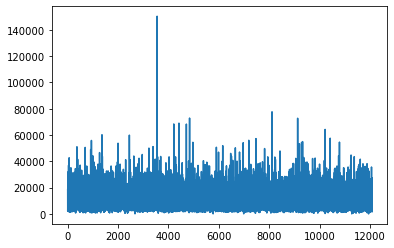

In [6]:
#KWH plot

df.KWH.plot()

<AxesSubplot:xlabel='KWH', ylabel='Count'>

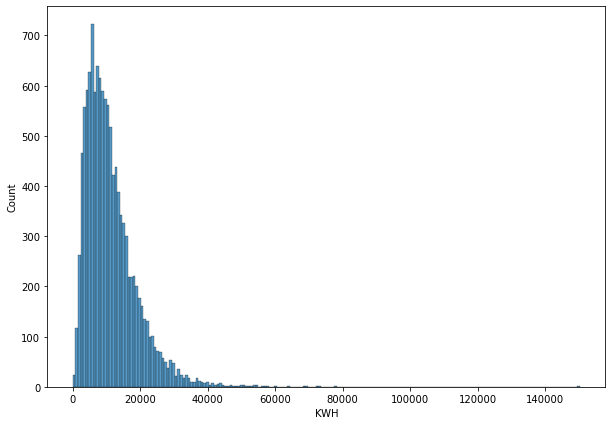

In [7]:
#histogram
plt.figure(figsize=(10, 7))
sns.histplot(df.KWH)

In [8]:
print("Skewness: %f" % df.KWH.skew())
print("Kurtosis: %f" % df.KWH.kurt())

Skewness: 2.114188
Kurtosis: 13.917123


- Can be seen from above that the data is positively skewed, deviating from normal distribution.

- Can also be seen from high Kurtosis value that the data is heavy tailed i.e there are lots of outliers

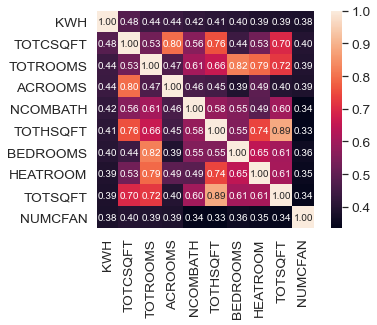

In [9]:
correlation = df.corr()

#consumption correlation matrix

k = 10 #number of variables for heatmap
cols = correlation.nlargest(k, 'KWH')['KWH'].index

cm = np.corrcoef(df[cols].values.T)

sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, 
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

<AxesSubplot:xlabel='TOTCSQFT', ylabel='KWH'>

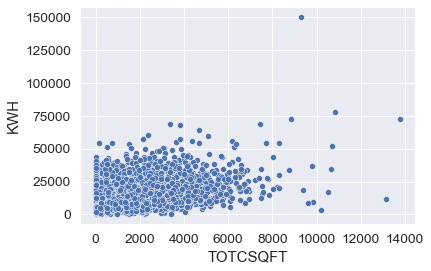

In [10]:
sns.scatterplot(data = df, x='TOTCSQFT', y='KWH')

<AxesSubplot:xlabel='TOTROOMS', ylabel='KWH'>

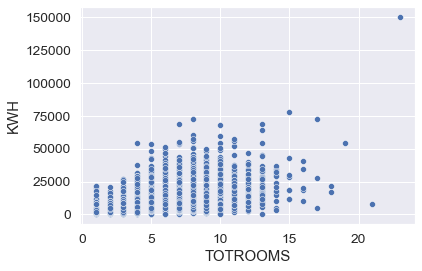

In [11]:
sns.scatterplot(data = df, x='TOTROOMS', y='KWH')

According to the provided documentation for the data:

>"Item nonresponse occurs when respondents do not know or refuse to answer certain items on the survey. A hot-deck imputation methodology, which fills in a missing value by copying a value from a similar case, was used for all variables with missing values. For each variable with missing values, a statistical model was used to determine a set of related variables. These related variables were used to identify statistically similar cases, which “donated” their values to the case with missing items"

- Therefore I will work under the assumption that all missing data has been dealt with (df.isna().sum().sum() also returns 0) and move onto feature engineering

In [12]:
df.select_dtypes('object')

,METROMICRO,UR,NOCRCASH,NKRGALNC
0,METRO,U,-2,-2
1,METRO,U,-2,-2
2,METRO,U,-2,-2
3,METRO,U,-2,-2
4,METRO,U,-2,-2
...,...,...,...,...
12078,METRO,U,-2,-2
12079,METRO,U,-2,-2
12080,METRO,U,-2,-2
12081,METRO,U,-2,-2


In [13]:
cat_features = [i for i in df.columns if df.dtypes[i]=='object']

df[cat_features]

#Seems to me that NOCRCASH and NKRGALNC should be int datatypes

,METROMICRO,UR,NOCRCASH,NKRGALNC
0,METRO,U,-2,-2
1,METRO,U,-2,-2
2,METRO,U,-2,-2
3,METRO,U,-2,-2
4,METRO,U,-2,-2
...,...,...,...,...
12078,METRO,U,-2,-2
12079,METRO,U,-2,-2
12080,METRO,U,-2,-2
12081,METRO,U,-2,-2


In [14]:
# df.NOCRCASH = df.NOCRCASH.astype('int64')  <-- This line of code crashes, suggesting there might be some non-int/float values
set(df.NOCRCASH)

#Looking at the unique elements in the column we can see that there are some rows with just '.' as the value
#Therefore, the whole column is thought to be an object so lets remove the . from all the rows

{'-2',
 -2,
 '.',
 1,
 '1',
 10,
 '10',
 12,
 '12',
 15,
 16,
 2,
 20,
 '20',
 '24',
 24,
 25,
 28,
 3,
 '3',
 4,
 '4',
 40,
 5,
 '55',
 55,
 6,
 '6',
 8}

In [15]:
df = df[df.NOCRCASH != '.']

df.NOCRCASH = df.NOCRCASH.astype('int64')
df.NOCRCASH #all good now

0       -2
1       -2
2       -2
3       -2
4       -2
        ..
12078   -2
12079   -2
12080   -2
12081   -2
12082   -2
Name: NOCRCASH, Length: 12081, dtype: int64

In [16]:
# set(df.NKRGALNC) #All rows have a number in them for this column but some are strings so just a conversion will be fine

df.NKRGALNC = df.NKRGALNC.astype('int64')
df.NKRGALNC

0       -2
1       -2
2       -2
3       -2
4       -2
        ..
12078   -2
12079   -2
12080   -2
12081   -2
12082   -2
Name: NKRGALNC, Length: 12081, dtype: int64

In [17]:
#DATA PRE-PROCESSING

cat_features = [i for i in df.columns if df.dtypes[i]=='object']
numeric_features = [i for i in df.columns if df.dtypes[i]!='object']

#Make new df for categorical features and then use get dummies to one hot encode
df_cat = df[cat_features]
df_cat = pd.get_dummies(df_cat)

#Get the merge going with numeric features
df_num = df[numeric_features]

# df_num = df_num.astype('int64')
df_processed = df_num.merge(df_cat, left_index=True, right_index=True)

## Decision Tree Model

- For starters, lets try a simple decision tree model

In [18]:
X = df_processed.drop(columns=['KWH', 'DOEID'])
y = df_processed.KWH

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Train RMSE is 1890.5962479421269
Train R2 score is 0.94
Test RMSE is 6600.850551243525
Test R2 score is 0.18


Text(0, 0.5, 'Predicted Electric Consumption')

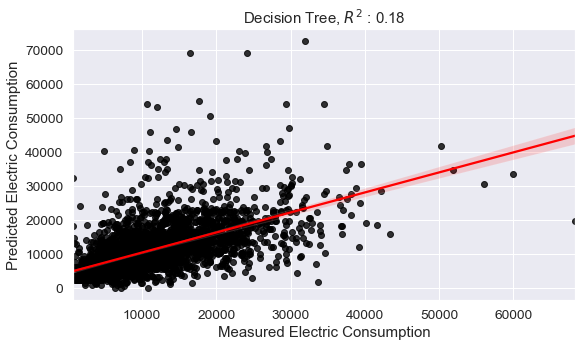

In [19]:
tree = DecisionTreeRegressor(max_depth=15)
tree.fit(X_train, y_train)

#Train prediction
y_train_pred = tree.predict(X_train)
rmse = (np.sqrt(mean_squared_error(y_train, y_train_pred)))
r2 = round(tree.score(X_train, y_train),2)

print('Train RMSE is {}'.format(rmse))
print('Train R2 score is {}'.format(r2))

#Test prediction
y_pred = tree.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, y_pred)))
r2 = round(tree.score(X_test, y_test),2)

print('Test RMSE is {}'.format(rmse))
print('Test R2 score is {}'.format(r2))

cols = ['y_test', 'y_pred']

results = pd.DataFrame(columns=cols)
results.y_test = list(y_test)
results.y_pred = y_pred

fig, ax = plt.subplots(figsize=(9, 5))

sns.regplot(x=y_test, y='y_pred', data=results, scatter_kws={"color": "black"}, line_kws={"color": "red"}, fit_reg=True)
plt.title('Decision Tree, $R^{2}$ : '+str(r2))
plt.xlabel('Measured Electric Consumption')
plt.ylabel('Predicted Electric Consumption')

**Takeaways:**

- Tree model works great on training data but pretty badly on test data.
- Continuing to increase max_depth can lead a lot of overfitting, which is a fundamental property of decision trees
- The key intuition to make these types of models better is to use many bad models rather than one strong one.
    - Multiple overfitting estimators can be combined to average out into a good prediction. Therefore a random forest can be used to make an ensemble of parallel estimators, each of which over-fits the data, and averages the results to find a better classification.

## Random Forest

Train RMSE is 2161.632525157944
Train R2 score is 0.92
Test RMSE is 4425.350518762369
Test R2 score is 0.63


Text(0, 0.5, 'Predicted Electric Consumption')

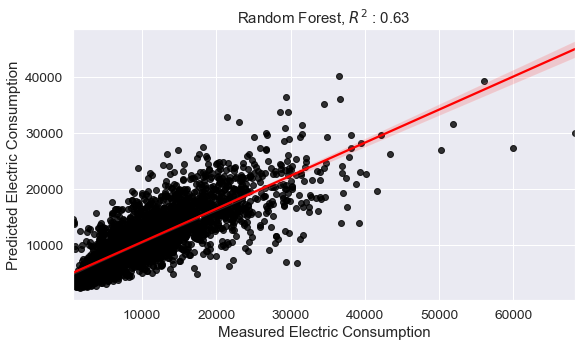

In [20]:
forest = RandomForestRegressor(n_estimators=100, max_depth=15, criterion='mse', random_state=42)

forest.fit(X_train, y_train)

y_train_pred = forest.predict(X_train)
rmse = (np.sqrt(mean_squared_error(y_train, y_train_pred)))
r2 = round(forest.score(X_train, y_train),2)

print('Train RMSE is {}'.format(rmse))
print('Train R2 score is {}'.format(r2))

y_pred = forest.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, y_pred)))
r2 = round(forest.score(X_test, y_test),2)

print('Test RMSE is {}'.format(rmse))
print('Test R2 score is {}'.format(r2))

cols = ['y_test', 'y_pred']

results = pd.DataFrame(columns=cols)
results.y_test = list(y_test)
results.y_pred = y_pred

fig, ax = plt.subplots(figsize=(9, 5))

sns.regplot(x=y_test, y='y_pred', data=results, scatter_kws={"color": "black"}, line_kws={"color": "red"}, fit_reg=True)
plt.title('Random Forest, $R^{2}$ : '+str(r2))
plt.xlabel('Measured Electric Consumption')
plt.ylabel('Predicted Electric Consumption')

- Random forest performs just as well on the training data but a noticeable jump in quality can be seen in the testing data, suggesting improvement in the model.

- Kind of makes sense as random forests tend to shine in scenarios where a model has a large number of features that individually have weak predicative power but much stronger power collectively

In [21]:
#Run a cross validation to get a better overview of the results

scores = cross_val_score(forest, X, y, cv=10)

print("=== All Accuracy Scores ===")
print(scores)
print('\n')
print("=== Mean Accuracy Score ===")
print("Mean Accuracy Score - Random Forest: ", scores.mean())

=== All Accuracy Scores ===
[0.65283353 0.59450416 0.58875359 0.56527956 0.63243595 0.6602169
 0.57246369 0.62472782 0.59619306 0.63121492]


=== Mean Accuracy Score ===
Mean Accuracy Score - Random Forest:  0.6118623183898739


#### Hyper Parameter Tuning to improve results

In [22]:
# number of trees in forest
n_estimators = [int(x) for x in np.linspace(start = 5, stop = 200, num = 10)]

# number of features at every split
max_features = ['auto', 'sqrt']

# max depth
max_depth = [int(x) for x in np.linspace(1, 50, num = 10)]
max_depth.append(None)

# create random grid
param = {
 'n_estimators': n_estimators,
 'max_features': max_features,
 'max_depth': max_depth
 }


# Random search of parameters
random_search = RandomizedSearchCV(estimator=forest, param_distributions=param, 
                                   n_iter=100, cv = 3, verbose=2, random_state=42, n_jobs=-1)

random_search.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 19.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 40.7min finished


RandomizedSearchCV(cv=3,
                   estimator=RandomForestRegressor(max_depth=15,
                                                   random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [1, 6, 11, 17, 22, 28, 33,
                                                      39, 44, 50, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'n_estimators': [5, 26, 48, 70, 91, 113,
                                                         135, 156, 178, 200]},
                   random_state=42, verbose=2)

In [23]:
# print results
print(random_search.best_params_)

{'n_estimators': 200, 'max_features': 'auto', 'max_depth': None}


Train RMSE is 1809.2267347567902
Train R2 score is 0.95
Test RMSE is 4404.636960534178
Test R2 score is 0.64


Text(0, 0.5, 'Predicted Electric Consumption')

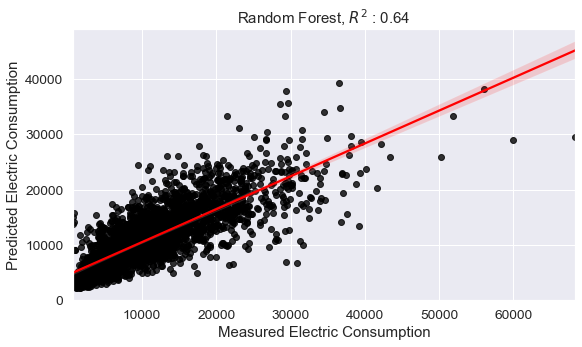

In [24]:
#Try again with the new parameters

forest2 = RandomForestRegressor(n_estimators=200, max_depth=None, max_features='auto', criterion='mse', random_state=42)

forest2.fit(X_train, y_train)

y_train_pred = forest2.predict(X_train)
rmse = (np.sqrt(mean_squared_error(y_train, y_train_pred)))
r2 = round(forest2.score(X_train, y_train),2)

print('Train RMSE is {}'.format(rmse))
print('Train R2 score is {}'.format(r2))

y_pred = forest2.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, y_pred)))
r2 = round(forest2.score(X_test, y_test),2)

print('Test RMSE is {}'.format(rmse))
print('Test R2 score is {}'.format(r2))

cols = ['y_test', 'y_pred']

results = pd.DataFrame(columns=cols)
results.y_test = list(y_test)
results.y_pred = y_pred

fig, ax = plt.subplots(figsize=(9, 5))

sns.regplot(x=y_test, y='y_pred', data=results, scatter_kws={"color": "black"}, line_kws={"color": "red"}, fit_reg=True)
plt.title('Random Forest, $R^{2}$ : '+str(r2))
plt.xlabel('Measured Electric Consumption')
plt.ylabel('Predicted Electric Consumption')

In [25]:
scores = cross_val_score(forest, X, y, cv=10)

print("=== All Accuracy Scores ===")
print(scores)
print('\n')
print("=== Mean Accuracy Score ===")
print("Mean Accuracy Score - Random Forest: ", scores.mean())

=== All Accuracy Scores ===
[0.65283353 0.59450416 0.58875359 0.56527956 0.63243595 0.6602169
 0.57246369 0.62472782 0.59619306 0.63121492]


=== Mean Accuracy Score ===
Mean Accuracy Score - Random Forest:  0.6118623183898739


- The improvement in results is extremely negligible. Theoretically a hyper parameter tuning should improve the model further and maybe the solution here is to widen the parameters more but this was already taking a long time to run on my computer.